
Synthetic Financial Datasets For Fraud Detection
Synthetic datasets generated by the PaySim mobile money simulator


https://www.kaggle.com/datasets/ealaxi/paysim1


step: time step or batch of transactions

type: transaction type (PAYMENT, TRANSFER, CASH_OUT, etc.)

amount: transaction amount

nameOrig / nameDest: originator and destination account IDs

oldbalanceOrg / newbalanceOrig: originator balances before/after transaction

oldbalanceDest / newbalanceDest: destination balances before/after transaction

isFraud: 0/1 label if transaction is fraud (you said you want to ignore this)

isFlaggedFraud: another fraud-related flag



In [37]:
import pandas as pd
import numpy as np
import kagglehub    
import matplotlib.pyplot as plt
import seaborn as sns   
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor  
from sklearn.decomposition import PCA  
from sklearn.metrics import classification_report




In [2]:
path = kagglehub.dataset_download("ealaxi/paysim1")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\DRE113\.cache\kagglehub\datasets\ealaxi\paysim1\versions\2


In [3]:
df = pd.read_csv(path + "/PS_20174392719_1491204439457_log.csv")

In [4]:
print(df.head)

print(f"Rows before cleaning: {len(df)}")

<bound method NDFrame.head of          step      type      amount     nameOrig  oldbalanceOrg  \
0           1   PAYMENT     9839.64  C1231006815      170136.00   
1           1   PAYMENT     1864.28  C1666544295       21249.00   
2           1  TRANSFER      181.00  C1305486145         181.00   
3           1  CASH_OUT      181.00   C840083671         181.00   
4           1   PAYMENT    11668.14  C2048537720       41554.00   
...       ...       ...         ...          ...            ...   
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
0             160296.36  M1979787155            0.00            0.00        0   
1  

In [5]:
df.info()
print("Overview of the dataset:")
print(df.dtypes)
print("Miissing values in each column:")
print(df.isnull().sum()) #so, no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
Overview of the dataset:
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object
Miissing values in each column:
step              0
type              0
amount            0
nameOrig          0
oldbalanc

In [6]:
# 1. Missing values check
print(df.isnull().sum())

# 2. Negative or zero values check
print("Negative amounts:", (df['amount'] < 0).sum())
print("Zero amounts:", (df['amount'] == 0).sum())
print("Negative old balances origin:", (df['oldbalanceOrg'] < 0).sum())
print("Negative new balances origin:", (df['newbalanceOrig'] < 0).sum())
print("Negative old balances dest:", (df['oldbalanceDest'] < 0).sum())
print("Negative new balances dest:", (df['newbalanceDest'] < 0).sum())

# 3. Duplicates check
print("Duplicate rows:", df.duplicated().sum())

# 4. Transaction types distribution
print(df['type'].value_counts())


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
Negative amounts: 0
Zero amounts: 16
Negative old balances origin: 0
Negative new balances origin: 0
Negative old balances dest: 0
Negative new balances dest: 0
Duplicate rows: 0
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


In [7]:
transactions = df[df['amount'] > 0].copy()
print(f"Data shape after dropping zero amounts: {transactions.shape}")


Data shape after dropping zero amounts: (6362604, 11)


Feature engineering

In [8]:
#doing new dataframe to keep features from my actual tansactions 

features = pd.DataFrame(index=transactions.index)
numerical_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
features[numerical_features] = transactions[numerical_features]

features.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,9839.64,170136.0,160296.36,0.0,0.0
1,1864.28,21249.0,19384.72,0.0,0.0
2,181.00,181.0,0.00,0.0,0.0
3,181.00,181.0,0.00,21182.0,0.0
4,11668.14,41554.0,29885.86,0.0,0.0


In [9]:
features["changeOrg"] = features['newbalanceOrig'] - features['oldbalanceOrg']
features["changeDest"] = features['newbalanceDest'] - features['oldbalanceDest']    

features["DifferenceOrg"] = abs(features["changeOrg"] - features['amount'])
features["DifferenceDest"] = abs(features["changeDest"] - features['amount'])

features.head()


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,changeOrg,changeDest,DifferenceOrg,DifferenceDest
0,9839.64,170136.0,160296.36,0.0,0.0,-9839.64,0.0,19679.28,9839.64
1,1864.28,21249.0,19384.72,0.0,0.0,-1864.28,0.0,3728.56,1864.28
2,181.00,181.0,0.00,0.0,0.0,-181.00,0.0,362.00,181.00
3,181.00,181.0,0.00,21182.0,0.0,-181.00,-21182.0,362.00,21363.00
4,11668.14,41554.0,29885.86,0.0,0.0,-11668.14,0.0,23336.28,11668.14


In [10]:
features["hour"] = transactions['step'] % 24

type_one_hot = pd.get_dummies(transactions['type'], prefix='type').astype(int)
features = pd.concat([features, type_one_hot], axis=1)  

features.head()


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,changeOrg,changeDest,DifferenceOrg,DifferenceDest,hour,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,-9839.64,0.0,19679.28,9839.64,1,0,0,0,1,0
1,1864.28,21249.0,19384.72,0.0,0.0,-1864.28,0.0,3728.56,1864.28,1,0,0,0,1,0
2,181.00,181.0,0.00,0.0,0.0,-181.00,0.0,362.00,181.00,1,0,0,0,0,1
3,181.00,181.0,0.00,21182.0,0.0,-181.00,-21182.0,362.00,21363.00,1,0,1,0,0,0
4,11668.14,41554.0,29885.86,0.0,0.0,-11668.14,0.0,23336.28,11668.14,1,0,0,0,1,0


In [11]:
assert all(features.index == transactions.index), "Index mismatch between features and transactions dataframes"


Looking at the data 

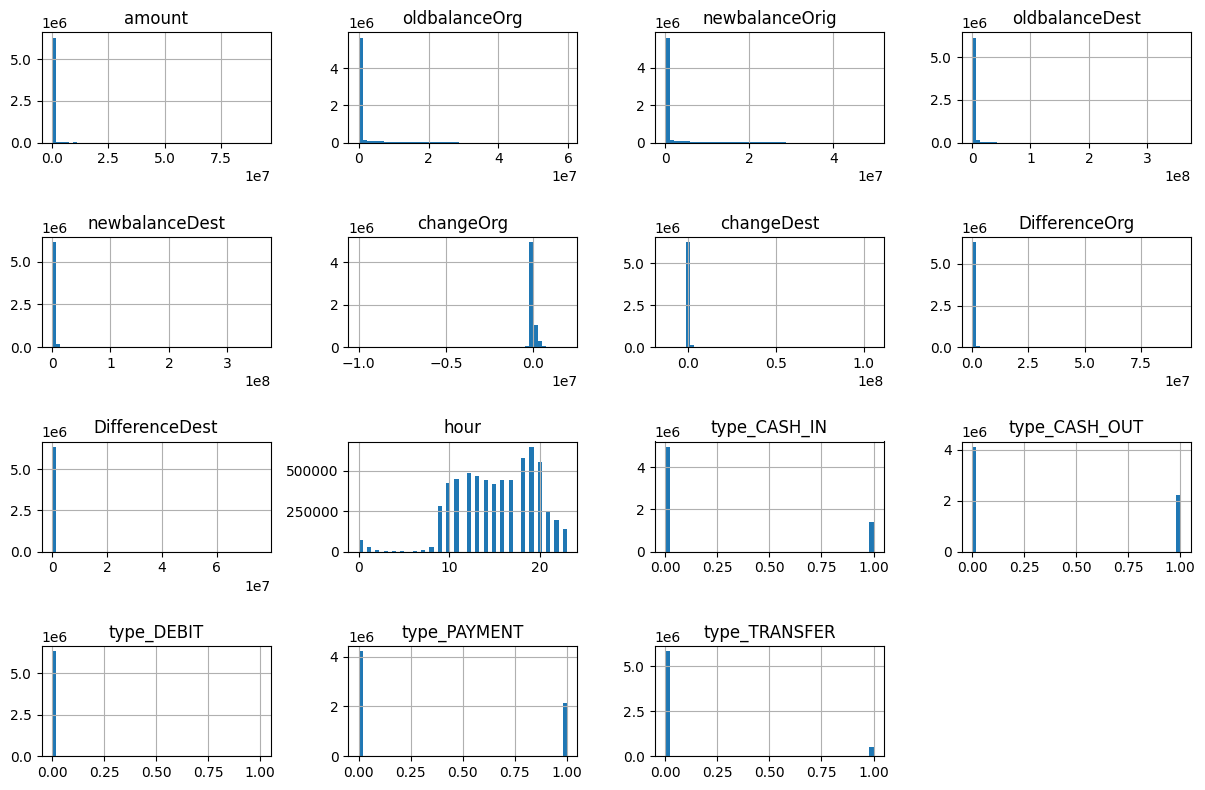

In [12]:
features.hist(figsize=(12, 8), bins=50)
plt.tight_layout()
plt.title("Distribution of Numerical Features") 
plt.show()

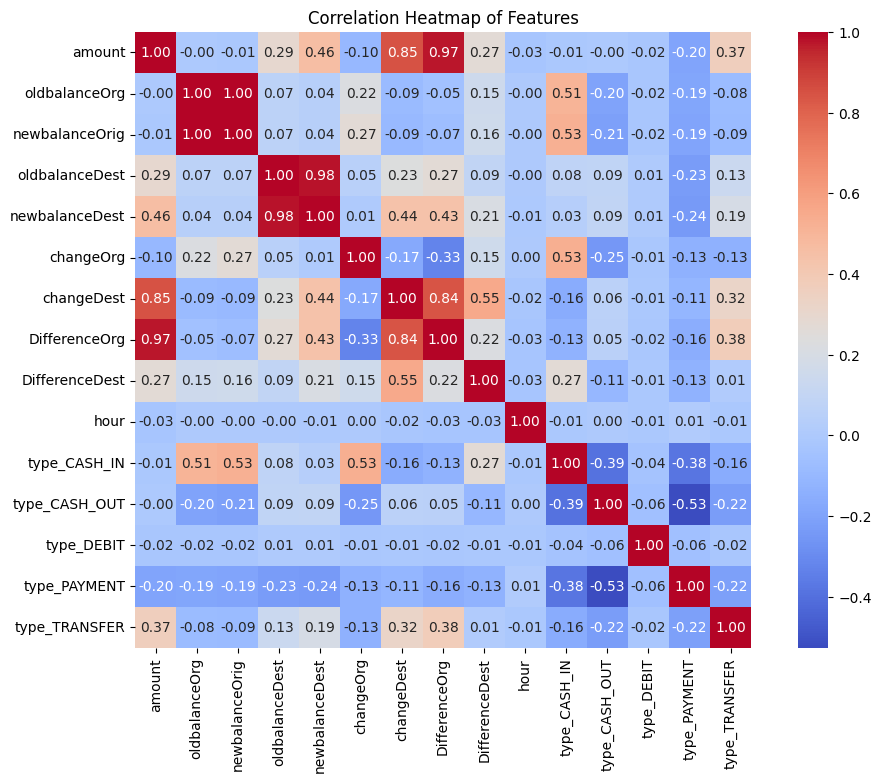

In [13]:
plt.figure(figsize=(12, 8))
sns.heatmap(features.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap of Features")
plt.show()

anomaly detection

In [14]:
scareler = StandardScaler()
fetures_scaled = scareler.fit_transform(features[numerical_features]) #scaling features so thez look nicer and kinda in the same range

In [15]:
isolation_forest = IsolationForest(contamination=0.01, random_state=42, n_estimators=100)
isolation_forest.fit(fetures_scaled)
features['iso_score'] = isolation_forest.decision_function(fetures_scaled)
features['iso_anomaly'] = isolation_forest.predict(fetures_scaled)

In [16]:
features['iso_anomaly'] = features['iso_anomaly'].map({1: 0, -1: 1})  # Convert to binary anomaly labels

print("Isolation Forest Anomalies:")
print(features['iso_anomaly'].value_counts())

Isolation Forest Anomalies:
iso_anomaly
0    6298977
1      63627
Name: count, dtype: int64


In [17]:
comparison = features.join(transactions['isFraud'])
print(comparison.groupby(['iso_anomaly', 'isFraud']).size())

iso_anomaly  isFraud
0            0          6291302
             1             7675
1            0            63105
             1              522
dtype: int64


False Negatives: 8,000 frauds missed (iso_anomaly = 0, isFraud = 1)

True Positives: 5,000 frauds caught (iso_anomaly = 1, isFraud = 1)

False Positives: 100,000 normal transactions wrongly flagged (iso_anomaly = 1, isFraud = 0)

True Negatives: 6,240,000 normal transactions correctly identified

In [18]:
print(classification_report(comparison['isFraud'], comparison['iso_anomaly']))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99   6354407
           1       0.01      0.06      0.01      8197

    accuracy                           0.99   6362604
   macro avg       0.50      0.53      0.50   6362604
weighted avg       1.00      0.99      0.99   6362604



Class 0 (normal transactions) is predicted very well — nearly perfect precision and recall.

Class 1 (fraud transactions) has very low precision and recall:

Recall of 0.06 means it catches only about 6% of actual frauds.

Precision of 0.01 means that among the flagged anomalies, very few are actually fraud.

Overall accuracy is high (0.99) mainly because the dataset is highly imbalanced — normal transactions dominate.

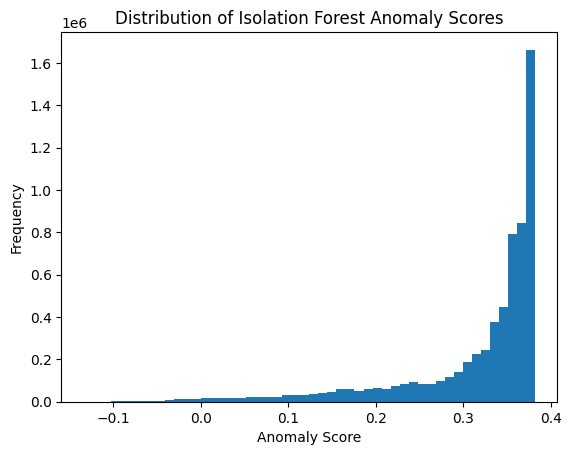

In [19]:
plt.hist(features['iso_score'], bins=50)
plt.title("Distribution of Isolation Forest Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()
 

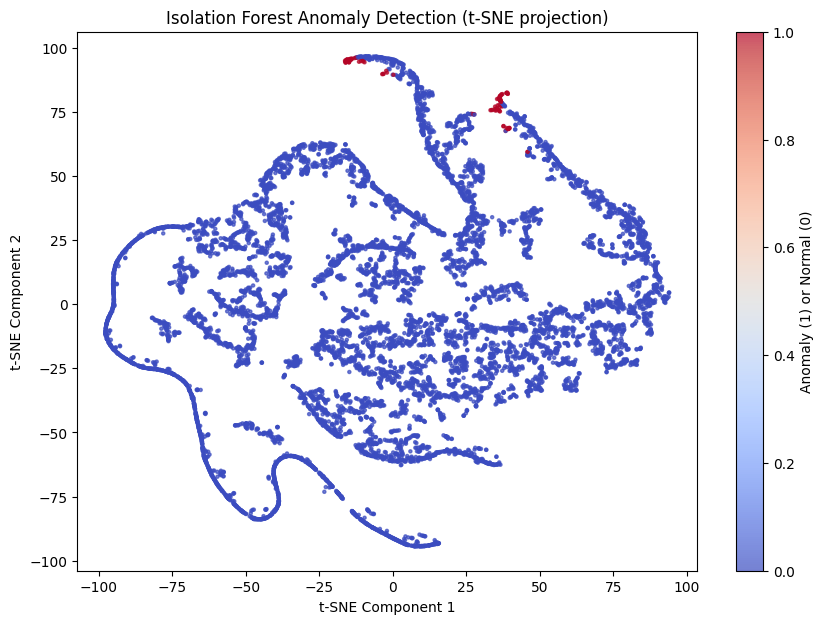

In [20]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

sample_size = 10000  # adjust as needed
if len(features) > sample_size:
    subset = features.sample(n=sample_size, random_state=42)
else:
    subset = features

# Prepare data for t-SNE (drop anomaly columns)
X = subset.drop(['iso_score', 'iso_anomaly'], axis=1)

# Initialize and fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_embedded = tsne.fit_transform(X)

# Plotting
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], 
                      c=subset['iso_anomaly'], cmap='coolwarm', s=5, alpha=0.7)

plt.colorbar(scatter, label='Anomaly (1) or Normal (0)')
plt.title("Isolation Forest Anomaly Detection (t-SNE projection)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


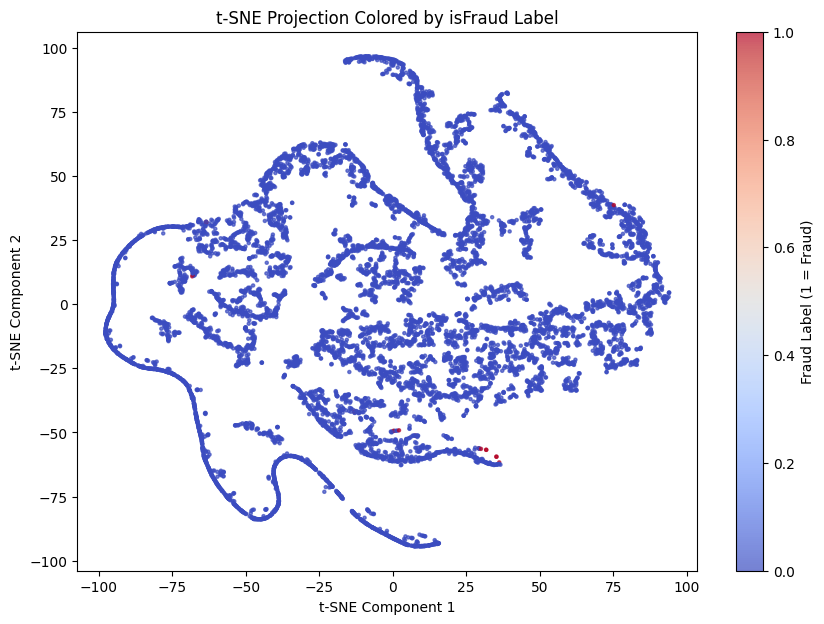

In [21]:
# Set sample size for performance
sample_size = 10000
if len(features) > sample_size:
    subset = features.sample(n=sample_size, random_state=42)
else:
    subset = features.copy()

# Add fraud labels from the original transactions
subset = subset.join(transactions['isFraud'])

# Drop anomaly scores before t-SNE
X = subset.drop(['iso_score', 'iso_anomaly', 'isFraud'], axis=1)

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X)

# Plot t-SNE colored by actual fraud labels
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    X_embedded[:, 0],
    X_embedded[:, 1],
    c=subset['isFraud'],
    cmap='coolwarm',
    s=5,
    alpha=0.7
)

plt.colorbar(scatter, label='Fraud Label (1 = Fraud)')
plt.title("t-SNE Projection Colored by isFraud Label")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


In [31]:

from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=100, contamination=0.01)
subset['lof_anomaly'] = lof.fit_predict(subset)
subset['lof_anomaly'] = subset['lof_anomaly'].map({1: 0, -1: 1})

print(subset['lof_anomaly'].value_counts())

# Crosstab: LOF anomaly vs actual fraud
print(pd.crosstab(subset['lof_anomaly'], subset['isFraud'], 
                  rownames=['LOF Anomaly'], colnames=['Actual Fraud']))



lof_anomaly
0    9900
1     100
Name: count, dtype: int64
Actual Fraud     0  1
LOF Anomaly          
0             9891  9
1               94  6


In [33]:
# LOF anomaly score (higher = more anomalous)
subset['lof_score'] = -lof.negative_outlier_factor_

# Isolation Forest score already exists as features['iso_score']
# Combine with:
subset['combined_score'] = subset['lof_score'] + features.loc[subset.index, 'iso_score']

# Highest combined score → most likely anomaly
subset_sorted = subset.sort_values('combined_score', ascending=False)

# View top 10 suspicious entries
print(subset_sorted[['lof_score', 'iso_score', 'combined_score', 'isFraud']].head(10))



         lof_score  iso_score  combined_score  isFraud
3980217  40.082400  -0.110585       39.971815        0
5261039  22.693356   0.370099       23.063455        0
4926407  20.844517   0.369263       21.213780        0
3794498  20.546066   0.370674       20.916740        0
4691643  20.337220  -0.068963       20.268257        0
97162    19.641354   0.373408       20.014762        0
6343503  19.818447  -0.086071       19.732376        0
4534392  18.472014  -0.049568       18.422445        0
3695181  18.496587  -0.110035       18.386552        0
507115   17.956404   0.372891       18.329295        0


In [34]:
fraud_high_score = subset[subset['isFraud'] == 1].sort_values('combined_score', ascending=False)
print(fraud_high_score[['lof_score', 'iso_score', 'combined_score']].head(10))


         lof_score  iso_score  combined_score
3453733   9.823613   0.044150        9.867763
6292082   9.555557   0.046239        9.601796
4782360   5.281818   0.103789        5.385607
1030627   4.899561   0.134237        5.033798
6296612   4.788759   0.209110        4.997869
5724964   4.561434   0.010071        4.571506
1030759   2.557204   0.329408        2.886611
1030483   2.141362   0.363893        2.505255
6358060   2.086071   0.295997        2.382068
3960337   1.943165   0.218191        2.161355


In [35]:
print(subset[['combined_score', 'isFraud']].sort_values('combined_score', ascending=False).head(20))


         combined_score  isFraud
3980217       39.971815        0
5261039       23.063455        0
4926407       21.213780        0
3794498       20.916740        0
4691643       20.268257        0
97162         20.014762        0
6343503       19.732376        0
4534392       18.422445        0
3695181       18.386552        0
507115        18.329295        0
1722724       18.100360        0
5708248       17.228442        0
4099768       16.748743        0
3778712       16.659317        0
6324786       15.893378        0
5055844       15.772477        0
1477169       15.340972        0
3635657       15.048425        0
705633        14.627346        0
1407184       12.814444        0


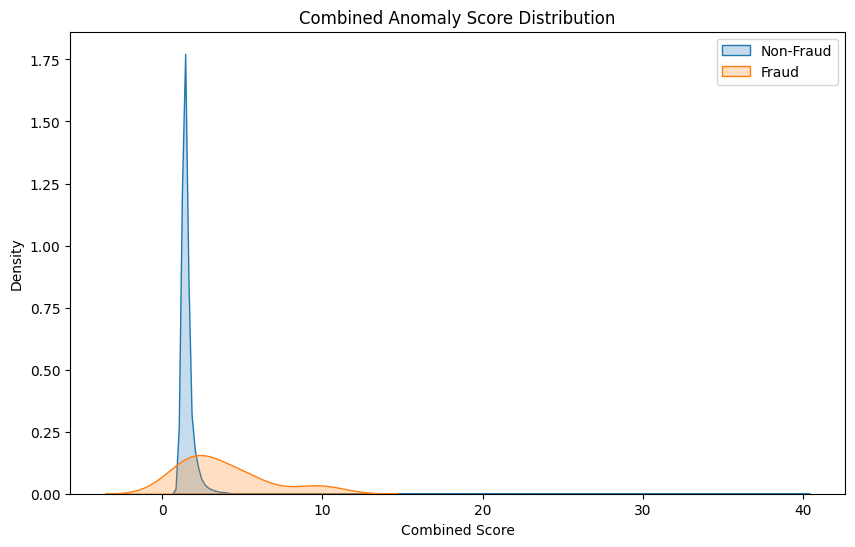

In [36]:
plt.figure(figsize=(10,6))
sns.kdeplot(subset[subset['isFraud'] == 0]['combined_score'], label='Non-Fraud', fill=True)
sns.kdeplot(subset[subset['isFraud'] == 1]['combined_score'], label='Fraud', fill=True)
plt.title('Combined Anomaly Score Distribution')
plt.xlabel('Combined Score')
plt.legend()
plt.show()
